In [96]:
import pandas as pd
import matplotlib.pyplot as plt

## Introduction

We start by opening the data and creating a pandas dataframe with all the information form the dataset. We set the "Start Date" field as the index to make data manipulation easier.

In [97]:
df = pd.read_csv("EVChargingStationUsage.csv")
df["Start Date"] = pd.to_datetime(df["Start Date"])
df["End Date"] = pd.to_datetime(df["End Date"], errors="coerce")
df["Charging Time (hh:mm:ss)"] = pd.to_timedelta(df["Charging Time (hh:mm:ss)"])
df = df.set_index(df["Start Date"])

C:\Users\vbran\AppData\Local\Temp\ipykernel_10748\1537354212.py:1: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("EVChargingStationUsage.csv")


We will only use fields described below for the task of predicting consumption. 

In [98]:
df = df[["Station Name", "Energy (kWh)", "Charging Time (hh:mm:ss)"]]
df

,Station Name,Energy (kWh),Charging Time (hh:mm:ss)
Start Date,,,
2011-07-29 20:17:00,PALO ALTO CA / HAMILTON #1,6.249457,0 days 01:54:03
2011-07-30 00:00:00,PALO ALTO CA / HAMILTON #1,0.106588,0 days 00:01:54
2011-07-30 08:16:00,PALO ALTO CA / HAMILTON #1,14.951777,0 days 04:17:28
2011-07-30 14:51:00,PALO ALTO CA / HAMILTON #1,7.159643,0 days 02:02:58
2011-07-30 18:51:00,PALO ALTO CA / HAMILTON #1,1.957765,0 days 00:43:54
...,...,...,...
2020-12-31 16:39:00,PALO ALTO CA / TED THOMPSON #3,1.841000,0 days 00:35:18
2020-12-31 16:48:00,PALO ALTO CA / WEBSTER #1,12.744000,0 days 02:14:04
2020-12-31 17:28:00,PALO ALTO CA / MPL #4,29.665000,0 days 05:08:12


## Data cleaning and reformating

Now we have to reformat the data so that instead of displaying consumption for each time a car was charged on a station, we want have aggrigated data with total consumption for the whole hour for each of the stations. We will use 2 assumptions to get this: The first is a constant consumption throughout the whole charging period and the second one is that every car starts charging immediately after arriving at the charging station. The second assumption is needed since we do not know the exact time of charging start and finish, but it seems reasonable to assume that people start charging their cars right after arriving at the charging station, but they might stay at the station longer than is needed for the car to charge completely for reasons. For example, if the start date is 00:00, end date 03:00 and charging duration is 2 hours, and charging consumed 10kWh of energy, we will assume the consumption between both 00:00 to 01:00 and 01:00 to 02:00 is 5kWh, and 0kWh between 02:00 and 03:00. In other words, we ignore the end data for this prediction.

To do this, we will create a function which takes in a dataframe for one station and creates another dataframe with hourly consumption data.

In [119]:
def get_hourly_consumption(df: pd.DataFrame) -> pd.Series:
    first_datetime = df.index.min().replace(minute=0, second=0)
    last_datetime = (df.index.max() + df.iloc[-1]["Charging Time (hh:mm:ss)"]).replace(minute=0, second=0)
    hourly_index = pd.date_range(first_datetime, last_datetime, freq="H")
    hourly_df = pd.Series(0.0, index=hourly_index)
    for index, row in df.iterrows():
        current_datetime = index
        total_consumption = row["Energy (kWh)"]
        total_duration = row["Charging Time (hh:mm:ss)"]
        end_datetime = index + total_duration
        # print(str(index) + " - " + str(end_datetime))
        while current_datetime < end_datetime:
            start_hour = current_datetime.replace(minute=0, second=0)
            end_hour = start_hour + pd.Timedelta(hours=1)
            sub_duration = min(end_hour, end_datetime) - current_datetime
            sub_consumption = total_consumption * sub_duration / total_duration
            hourly_df[start_hour] += sub_consumption
            current_datetime = end_hour
    return hourly_df

In [100]:
station_names = df['Station Name'].unique()
len(station_names)

47

There are a total of 47 stations in the dataset. Lets create a dictionary with station names as keys and hourly energy consumption dataframe as values.

In [120]:
hourly_consumption_by_station = dict()
for i, station_name in enumerate(station_names):
    station_df = df[df["Station Name"] == station_name]
    hourly_consumption = get_hourly_consumption(station_df)
    hourly_consumption_by_station[station_name] = hourly_consumption


## Seasonality and trend visualisation

Now we plot 3 graphs for 2 arbitrarily chosen stations to observe seasonality and trends in our data.

In [ ]:
def plot_consumption(hourly_consumption: pd.Series):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    plot_day_consumption(hourly_consumption, axs[0])
    plot_week_consumption(hourly_consumption, axs[1])
    plot_month_consumption(hourly_consumption, axs[2])

def plot_day_consumption(hourly_consumption: pd.Series, ax: plt.Axes):
    average_hourly_consumption = hourly_consumption.groupby(hourly_consumption.index.hour).mean()
    ax.boxplot(average_hourly_consumption)
    ax.set_xlabel("Hour of the day")
    ax.set_ylabel("Average consumption (kWh)")
    ax.set_title("Average consumption per hour of the day")

def plot_week_consumption(hourly_consumption: pd.Series, ax: plt.Axes):
    average_daily_consumption = hourly_consumption.groupby(hourly_consumption.index.dayofweek).mean()
    ax.scatter(average_daily_consumption.index, average_daily_consumption)
    ax.set_xlabel("Day of the week")
    ax.set_ylabel("Average consumption (kWh)")
    ax.set_title("Average consumption per day of the week")

def plot_month_consumption(hourly_consumption: pd.Series, ax: plt.Axes):
    average_monthly_consumption = hourly_consumption.groupby(hourly_consumption.index.month).mean()
    ax.scatter(average_monthly_consumption.index, average_monthly_consumption)
    ax.set_xlabel("Month")
    ax.set_ylabel("Average consumption (kWh)")
    ax.set_title("Average consumption per month")

[[2016-01-15    3.070892
2016-01-16    0.000000
2016-01-17    0.000000
2016-01-18    0.000000
2016-01-19    0.000000
                ...   
2020-12-27    0.000000
2020-12-28    0.000000
2020-12-29    0.000000
2020-12-30    0.000000
2020-12-31    0.000000
Length: 1813, dtype: float64], [2016-01-15 01:00:00    3.070892
2016-01-16 01:00:00    0.000000
2016-01-17 01:00:00    0.000000
2016-01-18 01:00:00    0.000000
2016-01-19 01:00:00    0.000000
                         ...   
2020-12-27 01:00:00    0.000000
2020-12-28 01:00:00    0.000000
2020-12-29 01:00:00    0.000000
2020-12-30 01:00:00    0.000000
2020-12-31 01:00:00    0.000000
Length: 1813, dtype: float64], [2016-01-15 02:00:00    3.070892
2016-01-16 02:00:00    0.000000
2016-01-17 02:00:00    0.000000
2016-01-18 02:00:00    0.000000
2016-01-19 02:00:00    0.000000
                         ...   
2020-12-27 02:00:00    0.000000
2020-12-28 02:00:00    0.000000
2020-12-29 02:00:00    0.000000
2020-12-30 02:00:00    0.000000
2020-12-3

ValueError: X must have 2 or fewer dimensions

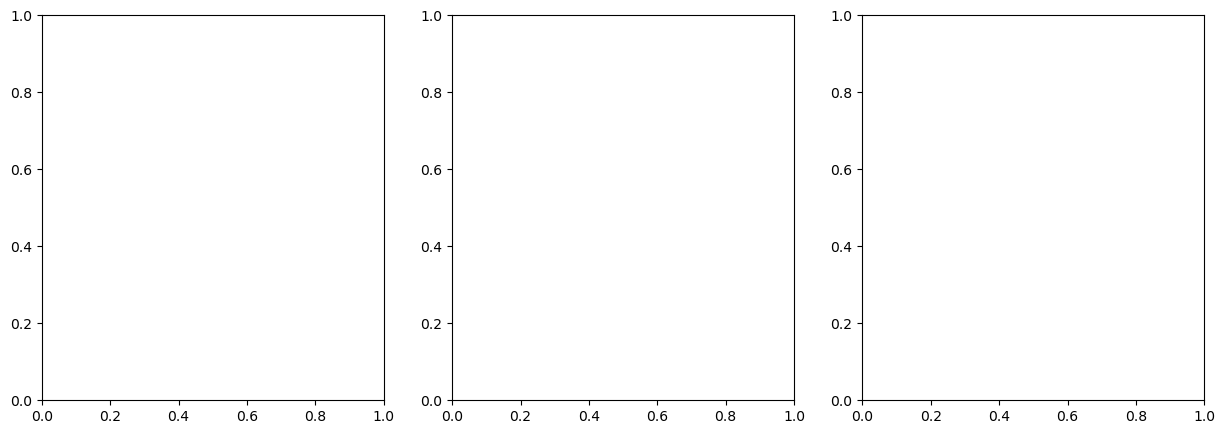

In [149]:
plot_consumption(hourly_consumption_by_station["PALO ALTO CA / CAMBRIDGE #1"])
plt.show()

# plot_consumption(hourly_consumption_by_station["PALO ALTO CA / HIGH #1"])
# plt.show()

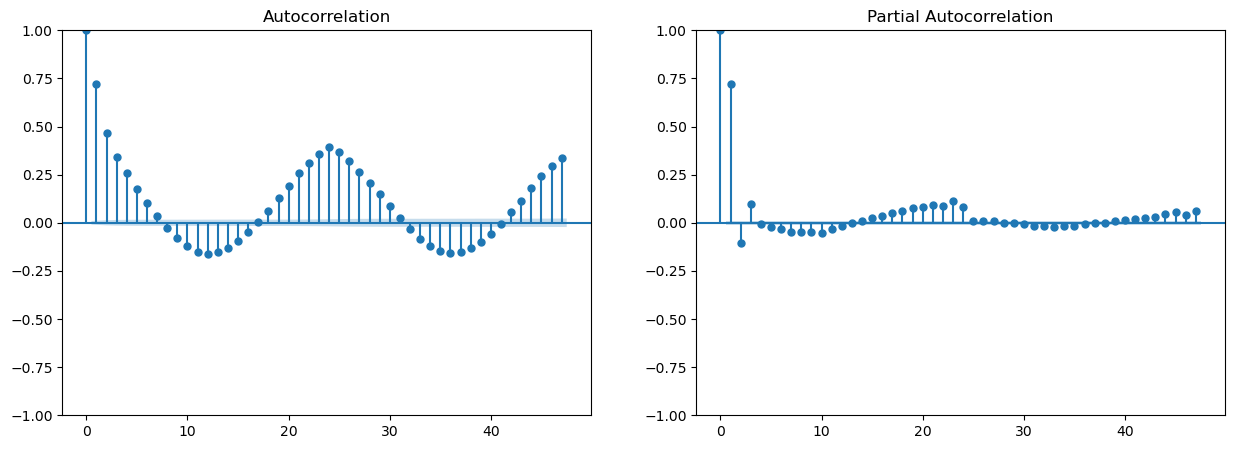

In [138]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(hourly_consumption_by_station["PALO ALTO CA / CAMBRIDGE #1"], ax=axs[0])
plot_pacf(hourly_consumption_by_station["PALO ALTO CA / CAMBRIDGE #1"], ax=axs[1])
plt.show()